# Project 3: Image Recognition in Medical Treatment
## Diagnosing Skin Lesions using Machine Learning in Image Processing 
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *19.04.2021* / Last Modified: *08.04.2021*

---

This notebook contains the step-by-step data science process performed on the *ISIC 2017* public test data and official training data on medical image recognition. The goal of this project was to extract and automatically analyse features from medical images of skin lesions in order to predict whether or not the person has ** using machine learning and image processing.

The initial data (containing the medical images, masked images and information on features and disease) was given for 150 medical images (equivalent to the public test data of the *ISIC 2017* challenge) by the project manager *Veronika *.
To develop more accurate models, we extended the initially given data by the official training data that could be obtained from the official [ISIC 2017 Website](https://challenge.isic-archive.com/data)

## Introduction
---
The amount of medical imaging - just as data in any other field - has increased tremendously within the last decade, making it more and more difficult to manually inspect medical images for diagnosis purposes.

Furthermore, people have proven to be hesitant of visiting doctors because of seemingly 'light' issues, which did not seem to be important enough to occupy a doctor's time. With skin diseases being especially effective in treatment if detected early, this is fatal. 
An easy-to-use app that implements automated detection of skin diseases from the sofa, would address this issue - ultimately saving lives.

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python Libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [PIL](https://pillow.readthedocs.io/en/stable/)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [SciKit Image](https://scikit-image.org/)
- [Scipy](https://www.scipy.org/)

In [1]:
%%capture
# uncomment lines with uninstalled packages

!pip install scikit-image
#!pip install scikit-learn
#!pip install pillow
#!pip install itertools

In [59]:
# external libraries
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import numpy as np                                     # used for numerical calculations and fast array manipulations
import matplotlib.pyplot as plt                        # visualisation of data
import seaborn as sns
from PIL import Image                                  # fork from PIL (python image library), deals with images in python

# specific functions
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # split data into train and test
from sklearn.preprocessing import StandardScaler # normalise features
from sklearn.neighbors import KNeighborsClassifier # k-nearest neighbour classifier
from sklearn.svm import SVC # support vector machine classifier
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.feature_selection import mutual_info_classif, SelectKBest # Univariate feature selection with mutual information for feature scoring

# python standard libraries
import json                                            # data transfer to json format
import os                                              # automates saving of export files (figures, summaries, ...)
import random                                          # randomness in coloring of plots
import re                                              # used for checking dateformat in data cleaning

Since this project makes heavy use of functions to achieve maximal efficiency, all functions are stored externally in the package structure `project3'. The following imports are necessary for this notebook to run properly.

In [3]:
#from project3.processing import ...
#from project3.save import ...
#from project3.features import ...
#from fyp2021p03g09_functions import *

**Remark**: All function used in this project are well documented in their *docstring*. To display the docstring and get an short summary of the function and the specifications of the input argument (including data tupe and small explanation) as well as their return value, type `?<function_name>` in Juptyer.

## Constants
---
To enhance the readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [4]:
PREPROCESS = False
COMPUTE_FEATURES = False

In [5]:
# path lookup dictionary to store the relative paths from the directory containing the jupyter notebooks to important directories in the project
PATH = {}

PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"
PATH['data']['external'] = "../data/external/"

PATH['images'] = 'images/'
PATH['masks'] = 'masks/'
PATH['filtered_images'] = 'filtered_images/'
PATH['dummy_images']= 'dummy_images/'
PATH['dummy_images_masks'] = 'dummy_images_masks/'
PATH['processed_dummy_images']= "processed_dummy_images/"

PATH['reports'] = "../reports/"

# filename lookup dictionary storing the most relevant filenames
FILENAME = {}
FILENAME['diagnosis'] = 'diagnosis.csv'
FILENAME['features'] = 'features.csv' 

# there are 57 superpixel images in the images that we want to deal with separately
FILENAME['images'] = sorted([image[:-4] for image in os.listdir(PATH['data']['raw'] + PATH['images']) if not re.match('.*super.*', image)])
FILENAME['superpixels'] = sorted([image for image in os.listdir(PATH['data']['raw'] + PATH['images']) if re.match('.*super.*', image)])
FILENAME['masks'] = sorted([mask[:-4] for mask in os.listdir(PATH['data']['raw'] + PATH['masks'])])
FILENAME['dummy_images'] = sorted([image[:-4] for image in os.listdir(PATH['data']['external'] + PATH['dummy_images'])])
FILENAME['dummy_images_masks'] = sorted([image[:-4] for image in os.listdir(PATH['data']['external'] + PATH['dummy_images_masks'])])

# defining three dictionaries to store data. each dictionary will reference several pandas dataframes
DATA = {}

NAMES = {}
NAMES['datasets'] = ['diagnosis', 'features']
NAMES['images'] = ['images', 'masks']

**TASK 0**
# Image Preprocessing
---
In this section we preprocess our image to make it nicer to deal with them in the later part of the project.

1. Crop Images and Masks to be bound by lesion
2. Make Width and Length an even number to be able to crop evenly
3. Maybe save filtered image with color

In [6]:
# helper function to make width and lengths even
def make_even(img):
    if img.size[0] % 2 != 0: #  making number of cols even
        img = np.array(img)
        mid = int(img.shape[1] / 2)
        img = np.delete(img, mid, axis=1)
        img = Image.fromarray(img)

    if img.size[1] % 2 != 0: # making number of rows even
        img = np.array(img)
        mid = int(img.shape[0] / 2)
        img = np.delete(img, mid, axis=0)
        img = Image.fromarray(img)
    
    return img

In [7]:
# preprocessing (170 seconds to run)
if PREPROCESS == True:
    try: 
        os.makedirs(PATH['data']['processed'] + PATH['images'])
        os.makedirs(PATH['data']['processed'] + PATH['masks'])
        os.makedirs(PATH['data']['processed'] + PATH['filtered_images'])
        os.makedirs(PATH['data']['external'] + PATH['processed_dummy_images'])
    except: print('Directories already exist.')

    for i in range(len(FILENAME['images'])):
        # get image names
        img_name = FILENAME['images'][i] + '.jpg'
        mask_name = FILENAME['masks'][i] + '.png'

        # open temporarily
        img = Image.open(PATH['data']['raw'] + PATH['images'] + img_name)
        mask = Image.open(PATH['data']['raw'] + PATH['masks'] + mask_name)

        # crop to only store lesion
        cropped_img = img.crop(mask.getbbox())
        cropped_mask = mask.crop(mask.getbbox())

        # make width and length even (two cases)
        cropped_img = make_even(cropped_img)
        cropped_mask = make_even(cropped_mask)

        # create filtered with color
        dummy = Image.new("RGB", cropped_img.size, 0)
        filtered_img = Image.composite(cropped_img, dummy, cropped_mask)
        
        # save to '../data/processed' in correct subfolder
        cropped_img.save(PATH['data']['processed'] + PATH['images'] + img_name)
        cropped_mask.save(PATH['data']['processed'] + PATH['masks'] + mask_name)
        filtered_img.save(PATH['data']['processed'] + PATH['filtered_images'] + img_name)
        
    for i in range(len(FILENAME['dummy_images'])):
        #same for dummy images
        img_name = FILENAME['dummy_images'][i] + '.png'
        mask_name = FILENAME['dummy_images_masks'][i] + '.png'
        img = Image.open(PATH['data']['external'] + PATH['dummy_images'] + img_name)
        cropped_img = img.crop(img.getbbox())
        cropped_mask = mask.crop(img.getbbox())
        cropped_img.save(PATH['data']['external'] + PATH['processed_dummy_images'] + img_name)
        cropped_mask.save(PATH['data']['external'] + PATH['processed_dummy_images'] + mask_name)

        
    print('Preprocessing Done')

*TASK 0.5*
# Data Exploration

---


### Loading in Data

---

The task involves different sources of data, namely:

> **Images**: 150 Medical Images of Skin Lesions

> **Masks**: 150 Binary Masks corresponding to each Image that masks the region of the Skin Lesion

> **Diagnosis**: Dataset storing whether or not the lesion was either *melanoma* or *seborrheic_keratosis* through binary values

> **Features**: Dataset storing the area and perimeter of the skin lesion for each image

We conveniently load in the csv datasets into individual `Pandas DataFrames` using the built-in pandas method `pd.read_csv()`. We store those in our `DATA` dictionary in the corresponding keys.

All images and masks are stored as `Image` objects of the `PIL` (*Python Image Library*) for convenient handling of image processing functionality.

In [8]:
# load in raw datasets 
DATA['diagnosis'] = pd.read_csv(PATH['data']['raw'] + FILENAME['diagnosis'])
DATA['features'] = pd.read_csv(PATH['data']['raw'] + FILENAME['features']) # not used in this project

In [9]:
# load in raw images and masks
DATA['images'] = [Image.open(PATH['data']['processed'] + PATH['images'] + FILENAME['images'][i] + '.jpg') for i in range(len(FILENAME['images']))]
DATA['masks'] = [Image.open(PATH['data']['processed'] + PATH['masks'] + FILENAME['masks'][i] + '.png') for i in range(len(FILENAME['masks']))]

DATA['generator'] = ( (Image.open(PATH['data']['processed'] + PATH['images'] + FILENAME['images'][i] + '.jpg'),
                           Image.open(PATH['data']['processed'] + PATH['masks'] + FILENAME['masks'][i] + '.png')) 
                           for i in range(len(FILENAME['images'])) )

#DATA['generator'], DATA_RAW['generator_copy'] = itertools.tee(DATA_RAW['generator'])

### Inspection of Datasets

---

We can now have a look at our two datasets to get a first impression for what kind of data we are dealing with. We start by reporting the number of records and fields/ variables in each of the datasets by using the shape property of the `pd.DataFrame`. We then continue to have an actual look into the data. Similiar to the head command in terminal, we can use the method `head()` onto our DataFrames, which outputs an inline representation of the first five data records of the dataset.

**Shape**

In [10]:
for dataset in NAMES['datasets']:
    print(f"{dataset.capitalize()}: {DATA[dataset].shape}")

Diagnosis: (150, 3)
Features: (150, 3)


**Diagnosis Dataset**

In [11]:
DATA['diagnosis'].head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [12]:
%%capture
# add diagnosis to df

# extract cols
mel = DATA['diagnosis']['melanoma']
ker = DATA['diagnosis']['seborrheic_keratosis']

# mask all cases
mel_mask = (mel == 1) & (ker == 0)
ker_mask = (mel == 0) & (ker == 1)
healthy_mask = (mel == 0) & (ker == 0)
both_mask = (mel == 1) & (ker == 1)

DATA['diagnosis']['diagnosis'] = 0
for i in range(DATA['diagnosis'].shape[0]):
    if mel_mask[i]: DATA['diagnosis']['diagnosis'].loc[i] = 2
    elif ker_mask[i]: DATA['diagnosis']['diagnosis'].loc[i] = 1
    else: DATA['diagnosis']['diagnosis'].loc[i] = 0

0: 78
1: 42
2: 30


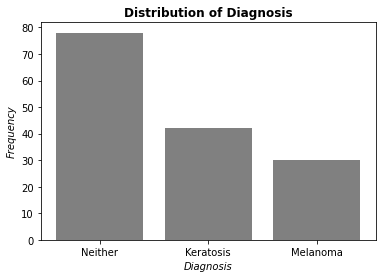

In [13]:
# distribution of diagnosis

diagnosis, counts = np.unique(DATA['diagnosis']['diagnosis'], return_counts=True)

for x in range(len(diagnosis)):
    print(f"{diagnosis[x]}: {counts[x]}")

# plot
fig,ax = plt.subplots()
ax.bar(diagnosis, counts, color='gray')
# maybe add text with numeric count
ax.set_title('Distribution of Diagnosis', fontweight='bold'); ax.set_xlabel('Diagnosis', fontstyle='italic'); ax.set_ylabel('Frequency', fontstyle='italic');
ax.set_xticks(diagnosis); ax.set_xticklabels(['Neither', 'Keratosis', 'Melanoma']);

As we can see, the majority of observed skin lesions was healthy (78 / 150), one fifth of the skin lesions were diagnosed with melanoma and approximately one fourth was diagnosed with keratosis. 

The two diseases are - as expected - mutually exclusive, meaning that a single skin lesion cannot be diagnosed with multiple diseases.

**Features Dataset**

The features dataset so far only stores the area and perimeter for each given medical image. This dataset will be used to store all of our handcrafted features at a later point in the project.

In [14]:
DATA['features'].head()

,id,area,perimeter
0,ISIC_0001769,216160.0,2013.0
1,ISIC_0001852,130493.0,1372.0
2,ISIC_0001871,205116.0,1720.0
3,ISIC_0003462,161705.0,1344.0
4,ISIC_0003539,317040.0,2063.0


### Inspection of Images
---
The main part of the project is to analyse medical images for a set of features. To do so, we can analyse both the original image and a binary mask provided in the raw data. In this section, we will look at examples of images and their corresponding mask to get a feel for the type of images we are dealing with and assess the quality of the masks.

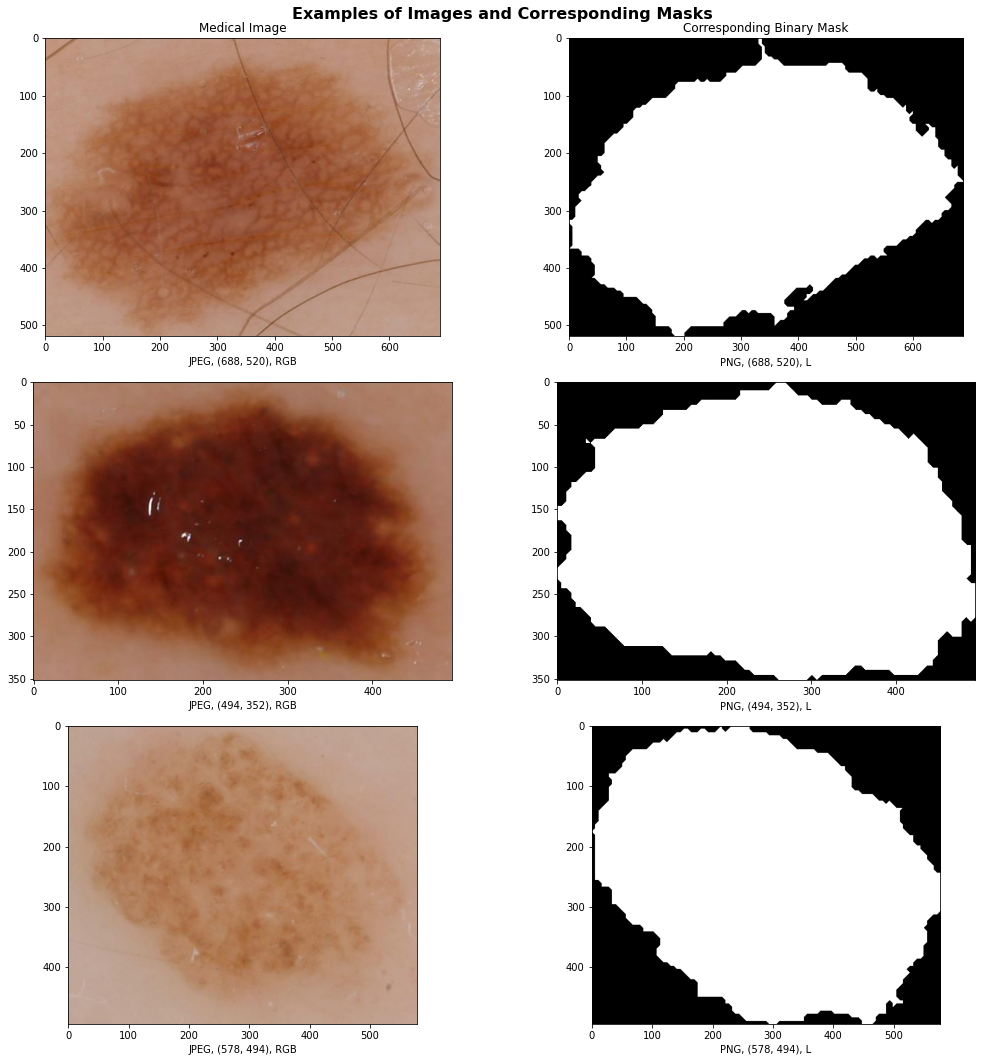

In [15]:
# load test image using PIL
filenames = sorted(os.listdir('../data/processed/images'))
masknames = sorted(os.listdir('../data/processed/masks'))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
fig.suptitle('Examples of Images and Corresponding Masks', fontsize=16, fontweight='bold')

for i in range(3):
    ex_img = Image.open('../data/processed/images/' + filenames[i])
    ex_img_mask = Image.open('../data/processed/masks/' + masknames[i])

    ax[i][0].imshow(ex_img)
    ax[i][0].set_xlabel(f"{ex_img.format}, {ex_img.size}, {ex_img.mode}");
    ax[i][1].imshow(ex_img_mask, cmap='gray')
    ax[i][1].set_xlabel(f"{ex_img_mask.format}, {ex_img_mask.size}, {ex_img_mask.mode}");

ax[0][0].set_title('Medical Image');
ax[0][1].set_title('Corresponding Binary Mask');

plt.tight_layout()

*TASK 1*
# Extracting Features 

---

We need to find quantitative measures of how to best classify the skin abnormality *keratosis*. The following handcrafted features are assessed during this project:

> **Compactness**. A quantitative measure of the shape of the lesion. The smaller the value, the more compact the lesion is. A perfect circle has a compactness score of roughly *1.4*.

> **Average Luminance**. A quantitative measure of the averaged brightness of the lesion. The higher the value, the lighter the lesion, and vice versa. Values range from 0 (meaning 100% black) to 255 (meaning 100% white).

> **Luminance Variability**. A quantitative measure to determine the variation of luminance of the lesion. The higher the value, the more variation can be found on the lesion. 

> **Average Colour**. A quantitative measure of the averaged colour of the lesion. Values are in RGB format

> **Colour Variability**. A quantitative measure to determine the variation of color of the lesion. The higher the value, the more variation can be found on the lesion. output in the format of (rvariation,gvariation,bvariation),average variation

> **Asymmetry**. A quantitative measure to assess the symmetry of the lesion. Measured through relative number of non-overlapping pixels in different rotations. The higher the value, the less symmmetric the lesion is. A perfect circle, should score a 0 asymmetry score.

> **Color Variability**. 

> **Border Smoothness**. 

In [16]:
def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    mask = np.where(np.array(mask)==255, 1, 0)
    
    area = np.sum(mask)
    # Measure perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    #fig, ax = plt.subplots(ncols=3, figsize=(12,3))
    #ax[0].imshow(mask, cmap='gray')
    #ax[1].imshow(mask_eroded, cmap='gray')
    #ax[2].imshow(image_perimeter, cmap='gray')

    # Now we have the perimeter image, the sum of all white pixels in it
    perimeter = np.sum(image_perimeter)
    
    return area, perimeter

In [17]:
# compactness
def get_compactness(mask):
    # might use given values for area and perimeter
    area, perimeter = measure_area_perimeter(mask)

    return ( ( perimeter ** 2) / (4 * np.pi * area ) )

In [18]:
# average luminance
def get_average_luminance(filtered_image): # image needs to be filtered for lesion
    gray = np.array(filtered_image.convert('L')) # converting to gray scale 
    return round(np.mean(gray[gray > 0]))

In [19]:
# luminance variability
def get_luminance_variability(filtered_image):
    gray = np.array(filtered_image.convert('L')) # converting to gray scale 
    return round(np.var(gray[gray > 0]))

In [20]:
# average color
def get_average_color(filtered_image): # image needs to be filtered for lesion
    r, g, b = filtered_image.split() # converting to separate channels  
    r= np.array(r) 
    g= np.array(g)
    b= np.array(b) 
    return round(np.mean(r[r > 0])),round(np.mean(g[g > 0])),round(np.mean(b[b > 0]))

In [21]:
# color variability
def get_color_variability(filtered_image): # image needs to be filteredd for lesion
    r, g, b = filtered_image.split() # converting to separate channels  
    r= np.array(r) 
    g= np.array(g)
    b= np.array(b) 
    rgb=(np.var(r[r > 0]),np.var(g[g > 0]),np.var(b[b > 0]))
    return np.mean(rgb)

In [22]:
def get_asymmetry(mask):
    return round(np.mean([asymmetry(mask), asymmetry(mask.rotate(90, expand=True))]),2)

In [23]:
# helper for asymmetry
def asymmetry(mask):
    # calculate basic properties of image
    width, length = mask.size  # requires even number of pixels in both dimensions
    size = width * length

    if width%2!=0:
        print("Uneven Number of Pixels. Can't calculate asymmetry.")

    # cut in half and fold
    left = mask.crop((0,0,(width/2), length)) 
    right = mask.crop((width/2,0,width,length))
    right = right.transpose(Image.FLIP_LEFT_RIGHT)

    # get binary array of unequal positions (the closer the sum to 0, the better the symmetry)
    diff = np.where(np.array(left) != np.array(right), 1, 0)

    #fig,ax = plt.subplots(ncols=4)
    #ax[0].imshow(left)
    #ax[1].imshow(right)
    #ax[2].imshow(diff)
    #ax[3].imshow(mask)
    #plt.show()

    return np.sum(diff) / size # percentage of asymmetric pixels

In [24]:
# border continuity
def get_border_shape():
    # cut the image in n parts from the midpoint of the lesion and measure the variance 
    # from drawing a straight line through thesee
    pass

## Evaluating Feature Extraction
---

Here we test the quality of the functions on sample lesions and dummy images.

In [25]:
# import dummy images
dummy1 = Image.open(PATH['data']['external']+PATH['processed_dummy_images']+'specialised01.png')
dummy2 = Image.open(PATH['data']['external']+PATH['processed_dummy_images']+'specialised02.png')
dummy1_mask = Image.open(PATH['data']['external']+PATH['processed_dummy_images']+'specialised01_mask.png')
dummy2_mask = Image.open(PATH['data']['external']+PATH['processed_dummy_image']+'specialised02_mask.png')

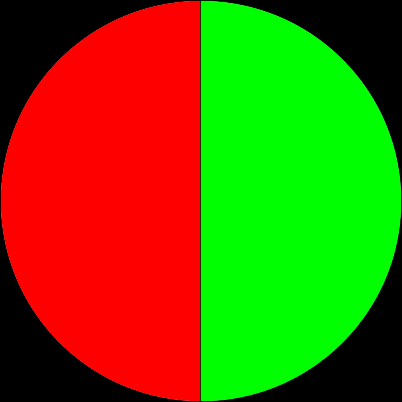

In [26]:
dummy1

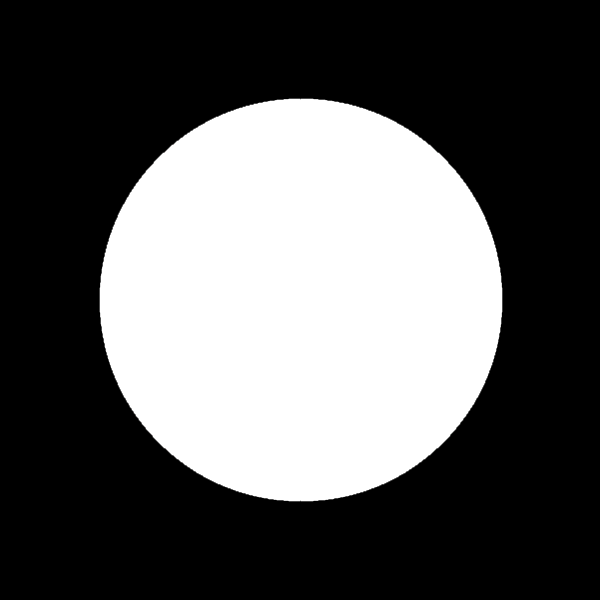

In [49]:
dummy1_mask

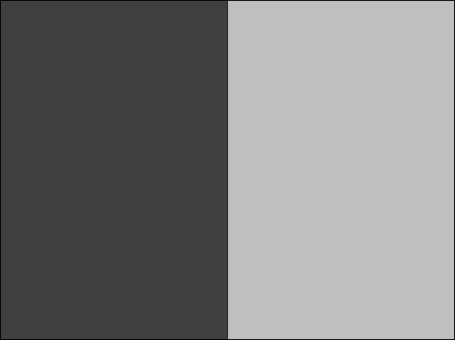

In [27]:
dummy2

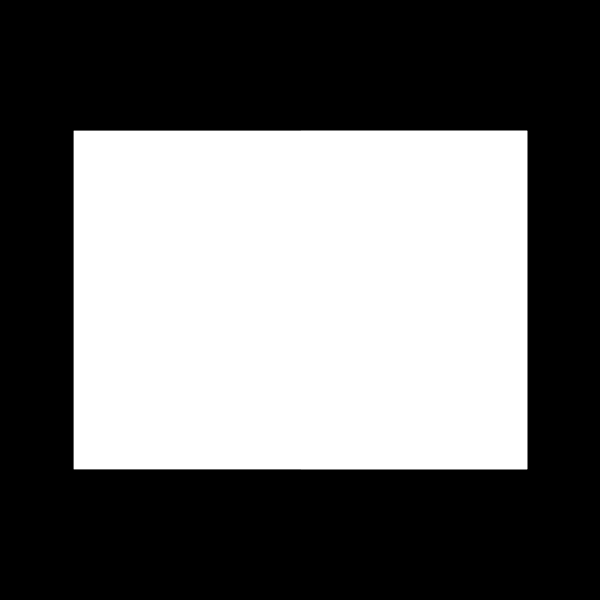

In [50]:
dummy2_mask

## compactness
testing compactness function on dummy images

dummy1 should have a low compactness value

dummy2 should have a high compactness value

In [94]:
# features to print:
# measure_area_perimeter()
# get_compactness()
# get_asymmetry()
# get_color_variability()
# get_average_color()
# get_average_luminance()
# get_luminance_variability()
dummies = [dummy1, dummy1_mask, dummy2, dummy2_mask]
feature_test_mask = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0001852_segmentation.png')
print(measure_area_perimeter(feature_test_mask))

for img in dummies:
    if img == dummy1:
        print("########## dummy1 ###########")

    if img == dummy2:
        print("########## dummy2 ###########")

# NEED TO FIX DUMMY IMAGE MASKS, IDK WTF IM DOING
    if img == dummy1_mask or img == dummy2_mask:
        print("area perim :", measure_area_perimeter(img))
        print("compactness:", get_compactness(img))
        print("asymmetry  :", get_asymmetry(img))
        continue

# NEED TO FIX INPUT FOR COLOR VARIABILITY AND AVERAGE COLOR
    if img == dummy1 or img == dummy2:
        # print("color vari :", get_color_variability(img))
        # print("avrg color :", get_average_color(img))
        print("avrg lumin :", get_average_luminance(img))
        print("lumin vari :", get_luminance_variability(img))

(130493, 1270)
########## dummy1 ###########
avrg lumin : 112
lumin vari : 1410
area perim : (0, 0)
compactness: nan
asymmetry  : 0.0
########## dummy2 ###########
avrg lumin : 126
lumin vari : 4125
area perim : (0, 0)
compactness: nan
asymmetry  : 0.0
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [29]:
feature_test_mask_1 = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0001852_segmentation.png') 
feature_test_mask_2 = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0001871_segmentation.png') #uneven pixel count
feature_test_mask_3 = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0012159_segmentation.png') #looks uneven on the x axis
feature_test_mask_4 = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0008524_segmentation.png') #looks uneven on the x axis
feature_test_mask_5 = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0013663_segmentation.png') #looks uneven on the y axis

In [30]:
###temporary test image
###mask smoothness is not even! some are smooth and others are jagged 
feature_test_img = Image.open(PATH['data']['processed'] + PATH['images'] + 'ISIC_0001852.jpg')
feature_test_mask = Image.open(PATH['data']['processed']+PATH['masks']+'ISIC_0001852_segmentation.png')
feature_test_filtered= Image.open(PATH['data']['processed']+PATH['filtered_images']+'ISIC_0001852.jpg')
feature_test_filtered_1 = Image.open(PATH['data']['processed']+PATH['filtered_images']+'ISIC_0013663.jpg')
feature_test_filtered_2 = Image.open(PATH['data']['processed']+PATH['filtered_images']+'ISIC_0001871.jpg')
feature_test_filtered_3 = Image.open(PATH['data']['processed']+PATH['filtered_images']+'ISIC_0012159.jpg')
feature_test_filtered_4 = Image.open(PATH['data']['processed']+PATH['filtered_images']+'ISIC_0008524.jpg')

### Compactness -wrong title?

### Area and perimeter

In [31]:
#DATA['features']

In [32]:
diag={}
list_of_colours=[]
#make a dictionary with easy to access diagnosis and a list for colour
for row in (DATA['features'].iterrows()):
    condition=row[1]["diagnosis"]
    diag[row[1]['id']]=condition
    #colour
    colour="black"
    if condition=="melanoma":
        colour="red"
    if condition=="keratosis":
        colour="black"
    list_of_colours.append(colour)

KeyError: 'diagnosis'

In [ ]:
#find areas and perimeters
import math
areas=DATA['features']["area"]
perimeters=DATA['features']["perimeter"]
sqrts_of_areas=[math.sqrt(x)for x in areas]
logs_of_areas=[math.log(x)for x in areas]
logs_of_perimeters=[math.log(x)for x in perimeters]

In [ ]:

fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10,10))
ax[0,0].scatter(perimeters,areas,c=list_of_colours,s=4)
ax[0,1].scatter(perimeters,sqrts_of_areas,c=list_of_colours,s=4)
ax[1,0].scatter(perimeters,logs_of_areas,c=list_of_colours,s=4)

#this one shows the 2 distinct groups best but the groups dont match the diagnoses, perhaps this is some error in methodology?
ax[1,1].scatter(logs_of_perimeters,logs_of_areas,c=list_of_colours,s=4)

In [33]:
DATA["features"]

,id,area,perimeter
0,ISIC_0001769,216160.0,2013.0
1,ISIC_0001852,130493.0,1372.0
2,ISIC_0001871,205116.0,1720.0
3,ISIC_0003462,161705.0,1344.0
4,ISIC_0003539,317040.0,2063.0
...,...,...,...
145,ISIC_0015443,9732988.0,13775.0
146,ISIC_0015445,12049938.0,19517.0
147,ISIC_0015483,8856478.0,13813.0
148,ISIC_0015496,8951522.0,13742.0


In [34]:
#check our area and perimeter function
area_difference=[]
perimeter_difference=[]
for row in (DATA['features'].iterrows()):
    area_difference.append(row[1]["area"]-row[1]["own_area"])
    perimeter_difference.append(row[1]["perimeter"]-row[1]["own_perimeter"])


#np.array(DATA['features']['area']) - np.array(DATA['features']['own_area'])

KeyError: 'own_area'

Text(0, 0.5, 'perimeter_difference')

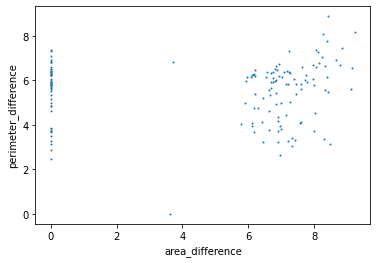

In [ ]:
import math
plt.scatter([math.log(x+1)for x in area_difference],[math.log(x+1)for x in perimeter_difference],s=1)
plt.xlabel("area_difference")
plt.ylabel("perimeter_difference")

## Append Features
---

Here we append the measured features to our `features.csv`.

In [35]:
features = ['compactness', 'area_perimeter', 'average_luminance', 'luminance_variability', 'average_color', 'color_variability', 'asymmetry']

feature_functions = {
    "area_perimeter": measure_area_perimeter,
    'compactness': get_compactness,
    'average_luminance': get_average_luminance,
    'luminance_variability': get_luminance_variability,
    'average_color': get_average_color,
    'color_variability': get_color_variability,
    'asymmetry': get_asymmetry
}

In [36]:
COMPUTE_FEATURES = True

In [37]:
# compute all features (execution time: 60s)
if COMPUTE_FEATURES == True:
    feature_dict = {feature: [] for feature in features if feature not in ['average_color', 'area_perimeter']}
    feature_dict['own_area'] = []
    feature_dict['own_perimeter'] = []
    feature_dict['average_red'] = []
    feature_dict['average_blue'] = []
    feature_dict['average_green'] = []

    for i in range(len(FILENAME['images'])):
        name = FILENAME['images'][i]
        img_name = FILENAME['images'][i] + '.jpg'
        mask_name = FILENAME['masks'][i] + '.png'

        # open temporarily
        #img = Image.open(PATH['data']['processed'] + PATH['images'] + img_name)
        filtered_img = Image.open(PATH['data']['processed'] + PATH['filtered_images'] + img_name)
        mask = Image.open(PATH['data']['processed'] + PATH['masks'] + mask_name)

        # measure features
        for feature in features:
            if feature in ['compactness', 'asymmetry']:
                feature_dict[feature].append(feature_functions[feature](mask))
            elif feature in ['average_luminance', 'luminance_variability', 'color_variability']:
                feature_dict[feature].append(feature_functions[feature](filtered_img))
            elif feature == 'average_color':
                r, g, b = feature_functions[feature](filtered_img)
                feature_dict['average_red'].append(r)
                feature_dict['average_green'].append(g)
                feature_dict['average_blue'].append(b)
            elif feature=="area_perimeter":
                area, perimeter = feature_functions[feature](mask)
                feature_dict["own_area"].append(area)
                feature_dict["own_perimeter"].append(perimeter)

In [38]:
# append to features.csv
if DATA['features'].shape[1] <= 3:
    DATA['features'] = pd.concat([DATA['features'], pd.DataFrame(feature_dict)], axis=1) # concatenating handcrafted features
    DATA['features'] = pd.concat([DATA['features'], DATA['diagnosis'][['melanoma', 'seborrheic_keratosis', 'diagnosis']]], axis=1) # concatenating diagnosis

In [39]:
DATA['features']

,id,area,perimeter,compactness,average_luminance,luminance_variability,color_variability,asymmetry,own_area,own_perimeter,average_red,average_blue,average_green,melanoma,seborrheic_keratosis,diagnosis
0,ISIC_0001769,216160.0,2013.0,1.460703,108,977,780.760582,0.10,215525,1989,155,66,96,0.0,0.0,0
1,ISIC_0001852,130493.0,1372.0,0.983582,66,1164,1065.616653,0.06,130493,1270,111,32,53,0.0,0.0,0
2,ISIC_0001871,205116.0,1720.0,0.999238,138,1094,825.166031,0.13,204639,1603,175,100,131,0.0,0.0,0
3,ISIC_0003462,161705.0,1344.0,0.743362,123,1207,1157.012146,0.03,161168,1227,160,86,114,0.0,0.0,0
4,ISIC_0003539,317040.0,2063.0,1.058382,110,1337,1194.831694,0.21,315977,2050,160,62,97,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,1.180344,101,452,507.443671,0.05,9726129,12011,139,64,89,0.0,0.0,0
146,ISIC_0015445,12049938.0,19517.0,2.387259,108,1946,1921.062199,0.29,12047598,19011,154,82,91,0.0,0.0,0
147,ISIC_0015483,8856478.0,13813.0,1.445050,114,1339,1307.218390,0.04,8852728,12679,142,92,105,0.0,0.0,0
148,ISIC_0015496,8951522.0,13742.0,1.490771,117,3638,3661.626976,0.10,8945061,12945,172,78,98,0.0,0.0,0


### Normalise Features
---
Here we normalise all features.

In [40]:
scaler = StandardScaler().fit(DATA['features'].loc[:, DATA['features'].columns != 'id'])
DATA['scaled_features'] = scaler.transform(DATA['features'].loc[:, DATA['features'].columns != 'id'])
DATA['scaled_features'] = pd.DataFrame(DATA["scaled_features"], columns=list(DATA['features'])[1:])
DATA['scaled_features']

,area,perimeter,compactness,average_luminance,luminance_variability,color_variability,asymmetry,own_area,own_perimeter,average_red,average_blue,average_green,melanoma,seborrheic_keratosis,diagnosis
0,-0.493031,-0.674136,0.583781,-0.321653,-0.103682,-0.233735,0.024820,-0.493023,-0.622345,0.019358,-0.694363,-0.343366,-0.5,-0.62361,-0.865277
1,-0.507605,-0.795608,-0.478044,-1.913495,0.204398,0.241546,-0.758982,-0.507492,-0.767994,-1.597886,-1.882703,-1.899734,-0.5,-0.62361,-0.865277
2,-0.494909,-0.729661,-0.443202,0.815377,0.089074,-0.159645,0.612672,-0.494875,-0.700537,0.754469,0.493977,0.923445,-0.5,-0.62361,-0.865277
3,-0.502295,-0.800914,-1.012648,0.246862,0.275240,0.394039,-1.346834,-0.502272,-0.776704,0.203136,0.004660,0.308137,-0.5,-0.62361,-0.865277
4,-0.475868,-0.664661,-0.311578,-0.245851,0.489413,0.457141,2.180277,-0.475929,-0.609988,0.203136,-0.834168,-0.307172,-0.5,-0.62361,-0.865277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.126062,1.554817,-0.040154,-0.586960,-0.968611,-0.689763,-0.954932,1.125357,1.407828,-0.568731,-0.764266,-0.596728,-0.5,-0.62361,-0.865277
146,1.520243,2.642952,2.645812,-0.321653,1.492730,1.668853,3.747881,1.520391,2.825830,-0.017398,-0.135145,-0.524339,-0.5,-0.62361,-0.865277
147,0.976942,1.562018,0.548945,-0.094247,0.492708,0.644657,-1.150883,0.976734,1.543146,-0.458464,0.214367,-0.017615,-0.5,-0.62361,-0.865277
148,0.993111,1.548563,0.650695,0.019456,4.280273,4.572976,0.024820,0.992446,1.597030,0.644202,-0.274949,-0.270977,-0.5,-0.62361,-0.865277


### Saving DataFrame
---

In [41]:
# save features and scaled features
DATA['features'].to_csv(PATH['data']['processed'] + 'features.csv')
DATA['scaled_features'].to_csv(PATH['data']['processed'] + 'scaled_features.csv')

## Evaluate Features
---

In this section, we are plotting the handcrafted features in order to see, whether any correaltions appear.



In [66]:
df = DATA['features']

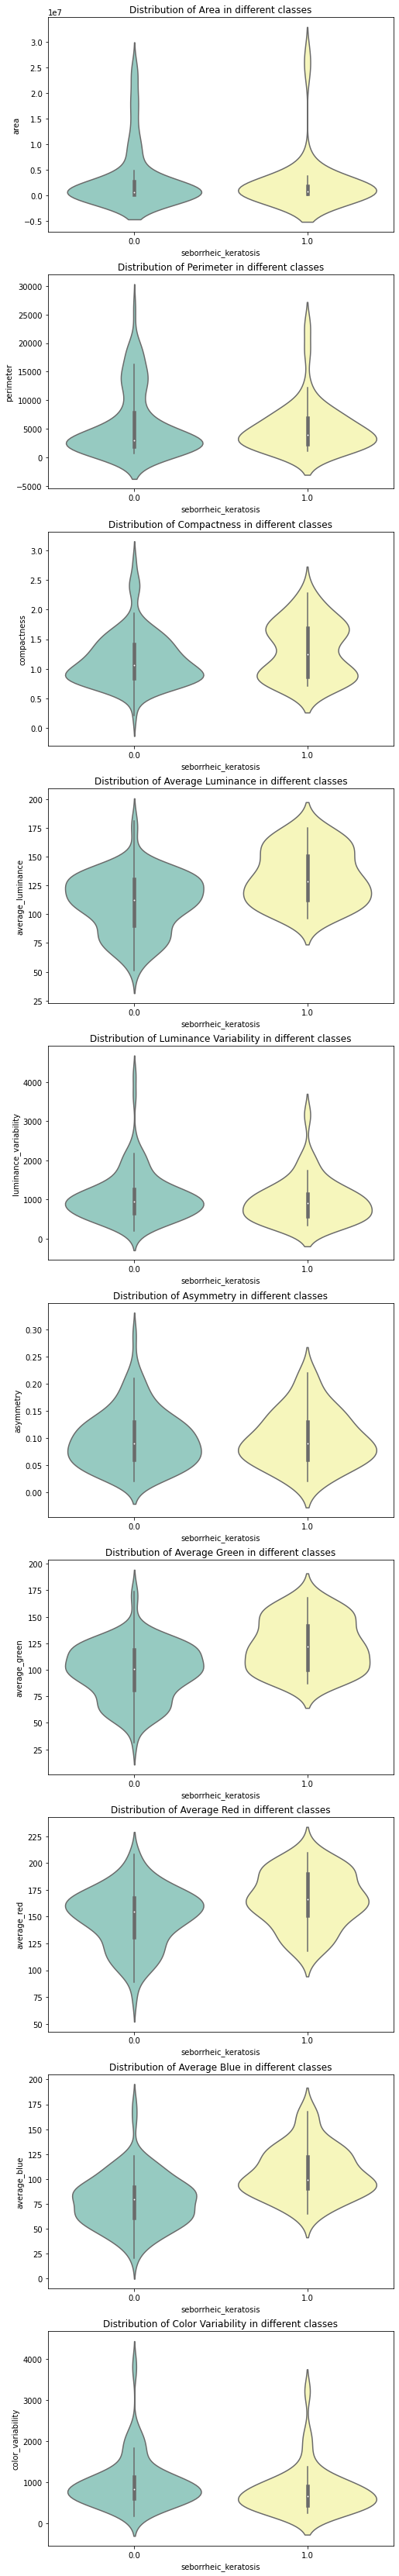

In [ ]:


fig, ax = plt.subplots(nrows=10, figsize=(8, 10*6))

for i, feature in enumerate(['area', 'perimeter', 'compactness', 'average_luminance', 'luminance_variability', 'asymmetry', 'average_green', 'average_red', 'average_blue', 'color_variability']):
    sns.violinplot(x='seborrheic_keratosis', 
                   y=feature, 
                   data=df,  
                   #scale="width",
                   ax=ax[i],
                   palette="Set3").set_title(f"Distribution of {feature.title().replace('_', ' ')} in different classes");

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


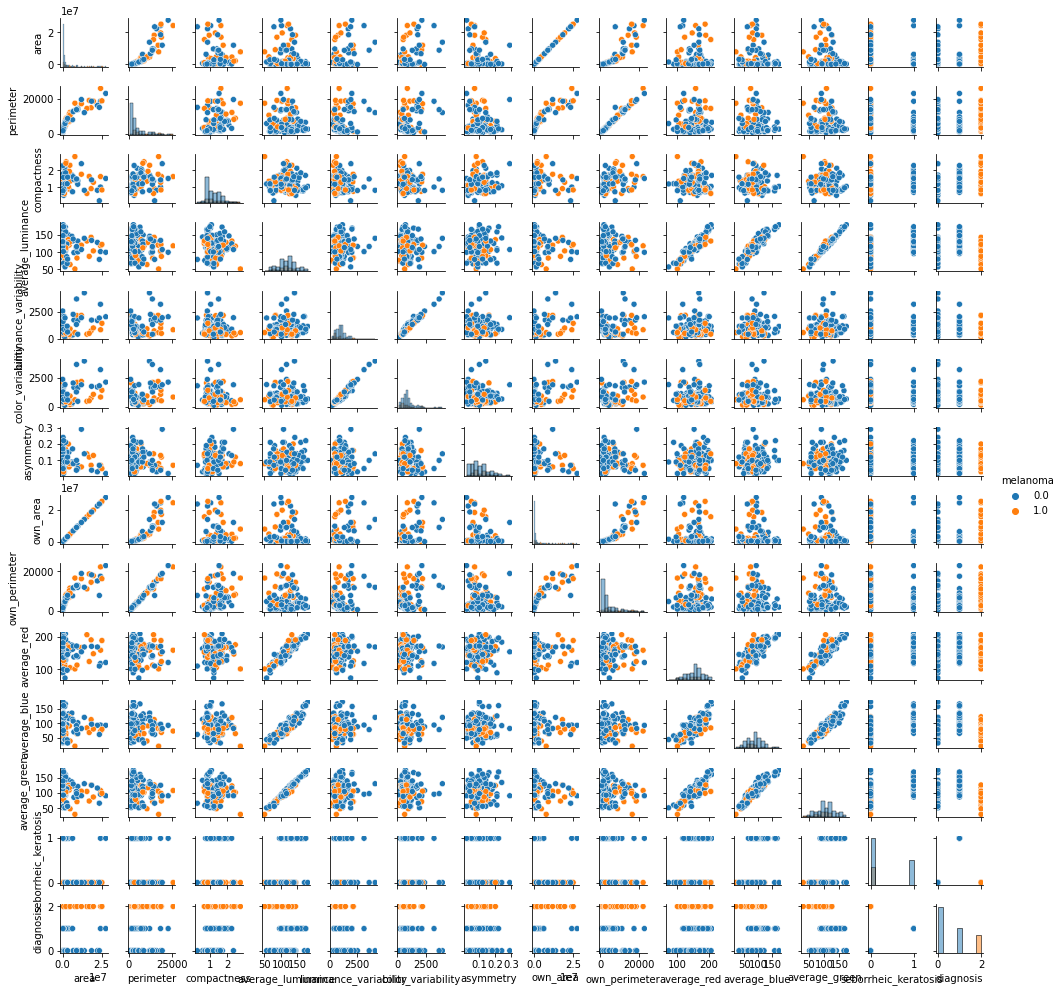

In [ ]:
sns.pairplot(df, hue='melanoma', size=1, diag_kind="hist"); #Size is how fat the points are 

<BarContainer object of 160 artists>

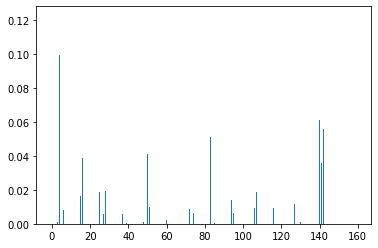

In [96]:
noise = np.random.RandomState(42).uniform(0,0.1, size=(df.shape[0], 150))


# Some noisy data not correlated
X = np.hstack((df[['area', 'perimeter', 'compactness', 'average_luminance', 'luminance_variability', 'asymmetry', 'average_green', 'average_red', 'average_blue', 'color_variability']], noise))
y = df['melanoma']

X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify=y, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev)

selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_

plt.bar(np.arange(0,160), scores, width=.2,label=r'Feature score')
#print(y)
#scores.shape

*TASK 2*
# Predict Diagnosis

---

[Comparison of Classifiers on SciKit Learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

In [ ]:
def knn_classifier(features, target=['melanoma'], k=5, scale=True):
    # define predictive and target labels
    X = DATA['features'][features]
    y = DATA['features'][target] 

    if scale:
    # normalise features
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)

    # split into training, validation and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    #X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

    # fit model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    return knn.score(X_test,y_test)

In [ ]:
knn_classifier(features=['compactness', 'average_luminance', 'asymmetry'])

NameError: name 'knn_classifier' is not defined

In [ ]:
DATA

{'diagnosis':          image_id  melanoma  seborrheic_keratosis  diagnosis
 0    ISIC_0001769       0.0                   0.0          0
 1    ISIC_0001852       0.0                   0.0          0
 2    ISIC_0001871       0.0                   0.0          0
 3    ISIC_0003462       0.0                   0.0          0
 4    ISIC_0003539       0.0                   0.0          0
 ..            ...       ...                   ...        ...
 145  ISIC_0015443       0.0                   0.0          0
 146  ISIC_0015445       0.0                   0.0          0
 147  ISIC_0015483       0.0                   0.0          0
 148  ISIC_0015496       0.0                   0.0          0
 149  ISIC_0015627       0.0                   0.0          0
 
 [150 rows x 4 columns],
 'features':                id        area  perimeter  compactness  average_luminance  \
 0    ISIC_0001769    216160.0     2013.0     1.460703                108   
 1    ISIC_0001852    130493.0     1372.0     0.98

In [45]:
DATA["scaled_features"]=DATA["scaled_features"].astype({"melanoma":int})
DATA["scaled_features"]

,area,perimeter,compactness,average_luminance,luminance_variability,color_variability,asymmetry,own_area,own_perimeter,average_red,average_blue,average_green,melanoma,seborrheic_keratosis,diagnosis
0,-0.493031,-0.674136,0.583781,-0.321653,-0.103682,-0.233735,0.024820,-0.493023,-0.622345,0.019358,-0.694363,-0.343366,0,-0.62361,-0.865277
1,-0.507605,-0.795608,-0.478044,-1.913495,0.204398,0.241546,-0.758982,-0.507492,-0.767994,-1.597886,-1.882703,-1.899734,0,-0.62361,-0.865277
2,-0.494909,-0.729661,-0.443202,0.815377,0.089074,-0.159645,0.612672,-0.494875,-0.700537,0.754469,0.493977,0.923445,0,-0.62361,-0.865277
3,-0.502295,-0.800914,-1.012648,0.246862,0.275240,0.394039,-1.346834,-0.502272,-0.776704,0.203136,0.004660,0.308137,0,-0.62361,-0.865277
4,-0.475868,-0.664661,-0.311578,-0.245851,0.489413,0.457141,2.180277,-0.475929,-0.609988,0.203136,-0.834168,-0.307172,0,-0.62361,-0.865277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.126062,1.554817,-0.040154,-0.586960,-0.968611,-0.689763,-0.954932,1.125357,1.407828,-0.568731,-0.764266,-0.596728,0,-0.62361,-0.865277
146,1.520243,2.642952,2.645812,-0.321653,1.492730,1.668853,3.747881,1.520391,2.825830,-0.017398,-0.135145,-0.524339,0,-0.62361,-0.865277
147,0.976942,1.562018,0.548945,-0.094247,0.492708,0.644657,-1.150883,0.976734,1.543146,-0.458464,0.214367,-0.017615,0,-0.62361,-0.865277
148,0.993111,1.548563,0.650695,0.019456,4.280273,4.572976,0.024820,0.992446,1.597030,0.644202,-0.274949,-0.270977,0,-0.62361,-0.865277


In [46]:

features=['area', 'perimeter', 'compactness', 'average_luminance', 'luminance_variability', 'asymmetry', 'average_green', 'average_red', 'average_blue', 'color_variability']

In [47]:
#finding best kkn usng tree
X_train, X_test, y_train, y_test = train_test_split(DATA['scaled_features'][features], DATA['scaled_features']["melanoma"] , test_size=0.3, random_state=42)

from sklearn.tree import DecisionTreeClassifier
tree1 = DecisionTreeClassifier()
tree1trained = tree1.fit(X_train, y_train)

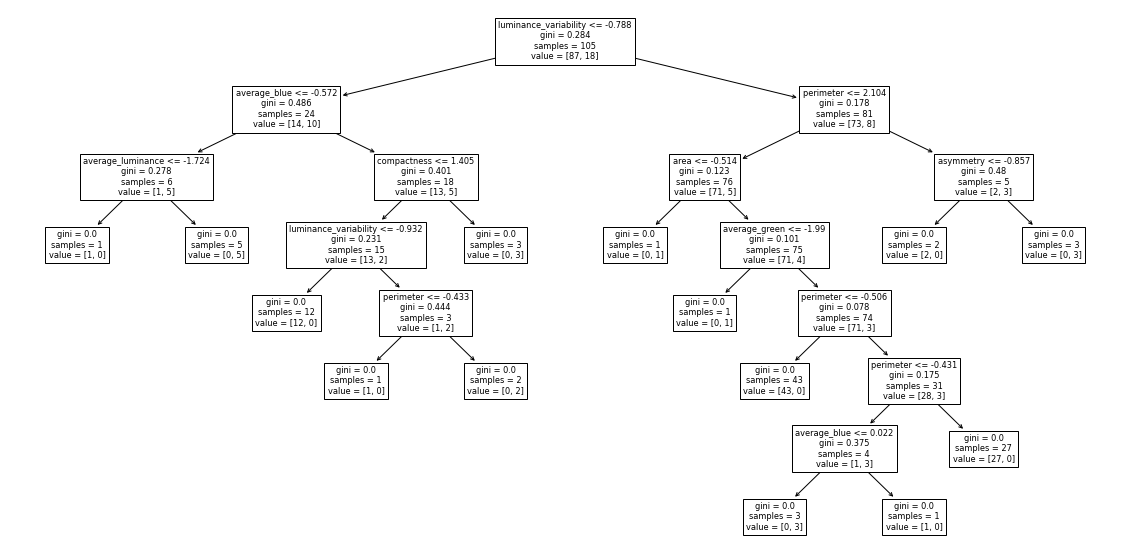

In [87]:
from sklearn import tree
fig,ax = plt.subplots(figsize=(20,10))
ax=tree.plot_tree(tree1trained,feature_names=features);

*TASK 3*
# Open Question: ...

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5a81e04-857d-4bae-844e-8fb924df483a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>